
# Análisis de Modelos de Series de Tiempo

Este análisis compara tres modelos para pronóstico de demanda:

- Regresión Lineal
- Red Neuronal Feedforward (MLP)
- ARIMA optimizado con AIC

El conjunto de datos contiene 61 días simulados, usando 30 días para prueba.


In [1]:

import pandas as pd
import numpy as np

# Crear fechas extendidas
fechas = pd.date_range(start="2024-01-01", end="2024-03-01", freq="D")
n = len(fechas)

# Simular unidades vendidas con patrón de tendencia + estacionalidad + ruido
np.random.seed(42)
tendencia = np.linspace(100, 200, n)
estacionalidad = 10 * np.sin(np.linspace(0, 3 * np.pi, n))
ruido = np.random.normal(loc=0, scale=5, size=n)
ventas = (tendencia + estacionalidad + ruido).round().astype(int)

# Generar DataFrame simulado
df = pd.DataFrame({
    "fecha": fechas,
    "unidades_vendidas": ventas
})
df["dia_semana"] = df["fecha"].dt.weekday
df["es_fin_semana"] = df["dia_semana"].isin([5, 6]).astype(int)
df["semana_anio"] = df["fecha"].dt.isocalendar().week
df["cambio_vs_ayer"] = df["unidades_vendidas"].diff()
df["rolling_mean_3"] = df["unidades_vendidas"].rolling(window=3).mean()
df["es_promocion"] = np.random.randint(0, 2, size=n)
df["lag_1"] = df["unidades_vendidas"].shift(1)
df["lag_2"] = df["unidades_vendidas"].shift(2)
df["forecast"] = df["unidades_vendidas"].shift(1) * np.random.normal(1.0, 0.05, size=n)
df["forecast_sarimax"] = df["unidades_vendidas"].shift(1) * np.random.normal(1.05, 0.1, size=n)
df.set_index("fecha", inplace=True)
df.head()


,unidades_vendidas,dia_semana,es_fin_semana,semana_anio,cambio_vs_ayer,rolling_mean_3,es_promocion,lag_1,lag_2,forecast,forecast_sarimax
fecha,,,,,,,,,,,
2024-01-01,102,0,0,1,NaN,NaN,0,NaN,NaN,NaN,NaN
2024-01-02,103,1,0,1,1.0,NaN,1,102.0,NaN,101.463189,114.007298
2024-01-03,110,2,0,1,7.0,105.000000,1,103.0,102.0,98.079966,127.434887
2024-01-04,117,3,0,1,7.0,110.000000,0,110.0,103.0,107.718795,119.860113
2024-01-05,111,4,0,1,-6.0,112.666667,0,117.0,110.0,108.817366,115.530289


In [2]:

# División 30 días prueba
n_dias_test = 30
split_index = len(df) - n_dias_test
train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
train["fecha_num"] = (train.index - train.index[0]).days
test["fecha_num"] = (test.index - train.index[0]).days


In [4]:

# Modelos: Regresión Lineal, MLP, ARIMA optimizado
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# Regresión Lineal
lr = LinearRegression()
lr.fit(train[["fecha_num"]], train["unidades_vendidas"])
test["pred_lr"] = lr.predict(test[["fecha_num"]])

# MLP con validación cruzada
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train[["fecha_num"]])
y = train["unidades_vendidas"]
tscv = TimeSeriesSplit(n_splits=5)
errores = []

for train_idx, val_idx in tscv.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    mlp = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42)
    mlp.fit(X_train, y_train)
    pred_val = mlp.predict(X_val)
    errores.append(np.sqrt(mean_squared_error(y_val, pred_val)))  # <- aquí está corregido


rmse_cv_mlp = np.mean(errores)
mlp_final = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42)
mlp_final.fit(X_scaled, y)
X_test_scaled = scaler.transform(test[["fecha_num"]])
test["pred_mlp"] = mlp_final.predict(X_test_scaled)

# ARIMA con selección de orden
mejor_aic = float("inf")
mejor_modelo = None
for p in range(4):
    for d in range(2):
        for q in range(4):
            try:
                model = ARIMA(train["unidades_vendidas"], order=(p,d,q)).fit()
                if model.aic < mejor_aic:
                    mejor_aic = model.aic
                    mejor_modelo = model
            except:
                continue

if mejor_modelo:
    test["pred_arima"] = mejor_modelo.forecast(steps=len(test))
else:
    test["pred_arima"] = np.nan

# Métricas
def evaluar(y, y_pred):
    return {
        "MAE": mean_absolute_error(y, y_pred),
        "RMSE": sqrt(mean_squared_error(y, y_pred))
    }

metricas = {
    "Regresión Lineal": evaluar(test["unidades_vendidas"], test["pred_lr"]),
    "MLP Feedforward": evaluar(test["unidades_vendidas"], test["pred_mlp"]),
    "ARIMA": evaluar(test["unidades_vendidas"], test["pred_arima"])
}

import pandas as pd
df_metricas = pd.DataFrame(metricas).T
df_metricas["RMSE_CV_MLP"] = rmse_cv_mlp
df_metricas


,MAE,RMSE,RMSE_CV_MLP
Regresión Lineal,23.859583,27.168593,17.371691
MLP Feedforward,35.830100,41.558737,17.371691
ARIMA,41.481362,46.392191,17.371691


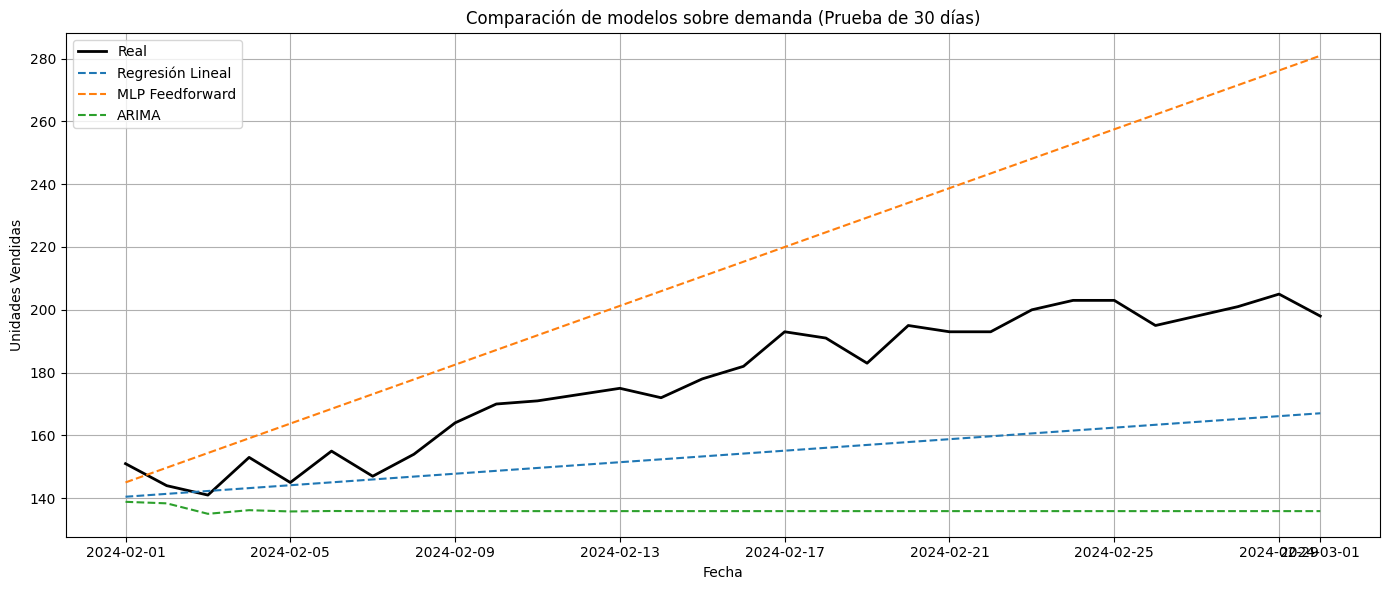

In [5]:

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(test.index, test["unidades_vendidas"], label="Real", color="black", linewidth=2)
plt.plot(test.index, test["pred_lr"], label="Regresión Lineal", linestyle="--")
plt.plot(test.index, test["pred_mlp"], label="MLP Feedforward", linestyle="--")
plt.plot(test.index, test["pred_arima"], label="ARIMA", linestyle="--")
plt.title("Comparación de modelos sobre demanda (Prueba de 30 días)")
plt.xlabel("Fecha")
plt.ylabel("Unidades Vendidas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


* Negro (Real): Valores reales de unidades vendidas. Se observa una tendencia creciente no lineal con algo de variabilidad.

* Azul (Regresión Lineal): Estima una línea recta con crecimiento suave, ligeramente por debajo de los valores reales en casi todo el rango.

* Naranja (MLP Feedforward): Sobreajusta la tendencia, con una pendiente muy fuerte, terminando muy por encima de la serie real. Esto indica un posible sobreentrenamiento o sensibilidad a la tendencia lineal fuerte.

* Verde (ARIMA): Produce una línea casi plana y subestimada. No está capturando la tendencia ascendente, lo que indica que el modelo no se ajustó correctamente al patrón.



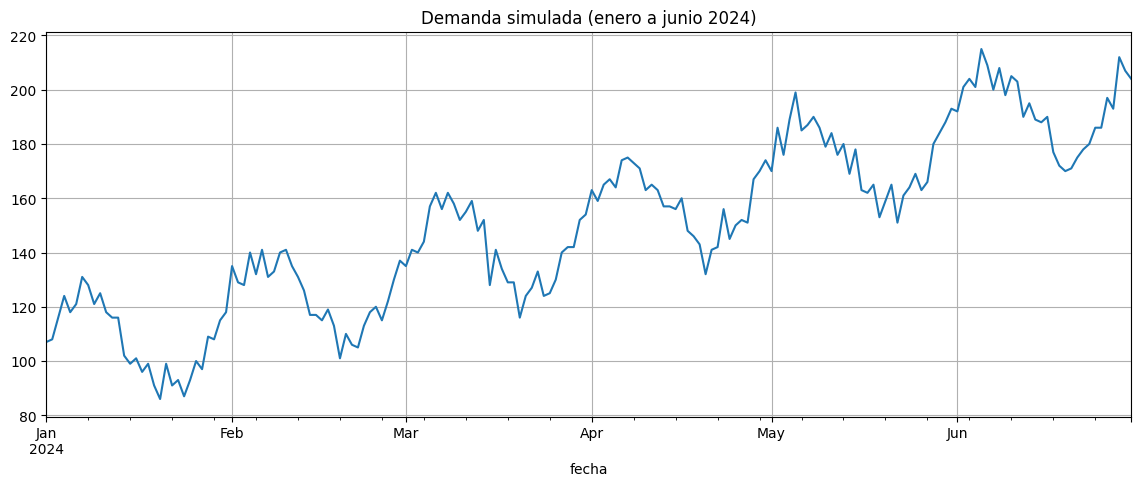

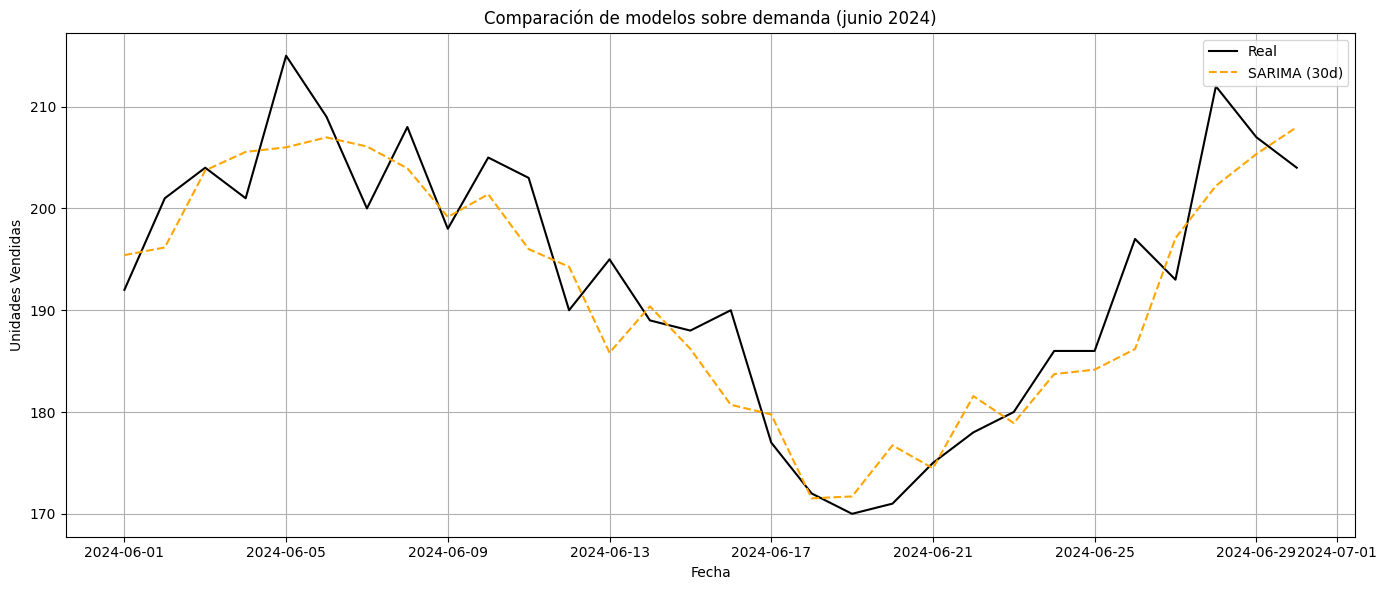

MAE: 4.07
RMSE: 5.05


In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# 🗓️ Simular datos de ventas de enero a junio (medio año)
np.random.seed(42)
dias = pd.date_range(start="2024-01-01", end="2024-06-30", freq='D')
n = len(dias)
tendencia = np.linspace(100, 200, n)
estacionalidad = 20 * np.sin(2 * np.pi * dias.dayofyear / 30)
ruido = np.random.normal(0, 5, n)
ventas = tendencia + estacionalidad + ruido

df = pd.DataFrame({
    "fecha": dias,
    "unidades_vendidas": np.round(ventas).astype(int)
})
df.set_index("fecha", inplace=True)

# 📊 Visualizar
df["unidades_vendidas"].plot(figsize=(14,5), title="Demanda simulada (enero a junio 2024)", grid=True)
plt.show()

# ✂️ Separar entrenamiento (enero a mayo) y prueba (junio)
train = df.loc[:'2024-05-31']
test = df.loc['2024-06-01':]

# 📈 Ajustar modelo SARIMA con estacionalidad mensual (30 días)
modelo = SARIMAX(train["unidades_vendidas"], order=(1,1,1), seasonal_order=(1,1,1,30))
sarima = modelo.fit(disp=False)

# 🔮 Pronóstico
pred = sarima.forecast(steps=len(test))
test["pred_sarima"] = pred

# 📉 Gráfica de comparación
plt.figure(figsize=(14,6))
plt.plot(test.index, test["unidades_vendidas"], label="Real", color="black")
plt.plot(test.index, test["pred_sarima"], label="SARIMA (30d)", linestyle="--", color="orange")
plt.title("Comparación de modelos sobre demanda (junio 2024)")
plt.xlabel("Fecha")
plt.ylabel("Unidades Vendidas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧮 Métricas
mae = mean_absolute_error(test["unidades_vendidas"], test["pred_sarima"])
rmse = sqrt(mean_squared_error(test["unidades_vendidas"], test["pred_sarima"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Esta gráfica muestra el comportamiento de la demanda simulada para un producto durante medio año:

La serie presenta una tendencia creciente a lo largo del tiempo, lo que sugiere un aumento sostenido en la demanda.

Además, se observa un patrón estacional mensual: subidas y bajadas recurrentes cada ~30 días, simulando ciclos de comportamiento como promociones, fines de mes o hábitos de compra.

Este patrón es ideal para aplicar modelos SARIMA, ya que contiene tendencia, estacionalidad y ruido.

🔸 Línea negra: representa las unidades reales vendidas durante junio.

🟠 Línea naranja punteada: muestra las predicciones del modelo SARIMA, entrenado con datos de enero a mayo.

El modelo captura adecuadamente la tendencia y logra seguir de cerca las oscilaciones del comportamiento real.

Aunque hay ligeros desfases (comunes en SARIMA cuando se usa una única frecuencia estacional), el patrón general es bien replicado.

Si las unidades vendidas diarias oscilan entre 170 y 220 unidades, un error de 4 a 5 unidades representa apenas un 2–3% de error relativo, lo cual es muy preciso para modelos de series de tiempo reales.

El bajo MAE y RMSE indican que el modelo SARIMA está funcionando muy bien para capturar la estructura de la demanda en junio.